In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
import pickle
with open('raw_data_20180811.pickle','rb') as handle:

    raw_data = pickle.load(handle)

In [5]:
kospi200 = pd.read_excel("C:\\Users\\axasd\\Downloads\\상장법인목록.xlsx")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

In [6]:
code_dict = {
    i : j for i, j in zip(kospi200["회사명"], kospi200["종목코드"])
}

In [7]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(sum_close_3 = raw_data[i].Close.rolling(window = 3).sum())
    raw_data[i] = raw_data[i].assign(sum_close_5 = raw_data[i].Close.rolling(window =5).sum())
    raw_data[i] = raw_data[i].assign(ma_5 = raw_data[i].Close.rolling(window = 5).mean())
    raw_data[i] = raw_data[i].assign(ma_10 = raw_data[i].Close.rolling(window = 10).mean())

In [8]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change = raw_data[i].Close.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(Y = np.where(raw_data[i]["pct_change"].fillna(0)>=0, 1,0))

In [9]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change2 = raw_data[i].sum_close_3.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(pct_change3 = raw_data[i].sum_close_5.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(sencond_Y = np.where(raw_data[i]["pct_change2"].fillna(0)>=0, 1,0))
    raw_data[i] = raw_data[i].assign(third_Y = np.where(raw_data[i]["pct_change3"].fillna(0)>=0, 1,0))

In [10]:
copy_keys = kospi200["종목코드"]

In [11]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].dropna(axis=0)

In [12]:
for i in copy_keys:
    if (len(raw_data[i]) < 252):
        del raw_data[i]

### Train, Test Split

In [ ]:
train = {}
train_idx = {}
test = {}
test_idx = {}
for code, df in raw_data.items():
    train[code] = df.iloc[:int(len(df)*0.8)][["Open","ma_5", "ma_10"]]
    train_idx[code] = df.iloc[:int(len(df)*0.8)]["sencond_Y"]
    test[code] = df.iloc[int(len(df)*0.8):][["Open","ma_5", "ma_10"]]
    test_idx[code] = df.iloc[int(len(df)*0.8):]["sencond_Y"]

### Scale 조정

In [16]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
li = ["Open","ma_5", "ma_10"]
for code in raw_data.keys():
    train[code][li] = std_scaler.fit_transform(train[code][li].values)
    test[code][li] = std_scaler.fit_transform(test[code][li].values)

### model 호출

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

log_clf = LogisticRegression()
DTC_clf = DecisionTreeClassifier()
svm_clf = SVC()

### Predict

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
score_list = pd.DataFrame(columns=('LR','DT','SVM'))
CM = pd.DataFrame(columns=('LR','DT','SVM'))
roc_auc_score = pd.DataFrame(columns=('LR','DT','SVM'))

for i in raw_data.keys():
    a=[]
    a1=[]
    X_train = train[i].values
    y_train = train_idx[i].values
    X_test = test[i].values
    y_test = test_idx[i].values
    for clf in (log_clf, DTC_clf, svm_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a.append(accuracy_score(y_test, y_pred))
        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
        a1.append([confusion_matrix(y_train, y_train_pred)])
    score_list.loc[i] = a
    CM.loc[i] = a1

In [55]:
roc_auc_score = pd.DataFrame(columns=('LR','SVM'))

for i in raw_data.keys():
    a2=[]
    X_train = train[i].values
    y_train = train_idx[i].values
    score=cross_val_predict(log_clf, X_train, y_train, cv=3,method="decision_function")
    fpr, tpr, thresholds = roc_curve(y_train, score)
    a2.append([auc(fpr, tpr)])
    
    score=cross_val_predict(svm_clf, X_train, y_train, cv=3,method="decision_function")
    fpr, tpr, thresholds = roc_curve(y_train, score)
    a2.append([auc(fpr, tpr)])
    roc_auc_score.loc[i] = a2

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  3., 42., 89., 61.]),
 array([0.33126935, 0.374613  , 0.41795666, 0.46130031, 0.50464396,
        0.54798762, 0.59133127, 0.63467492, 0.67801858, 0.72136223,
        0.76470588]),
 <a list of 10 Patch objects>)

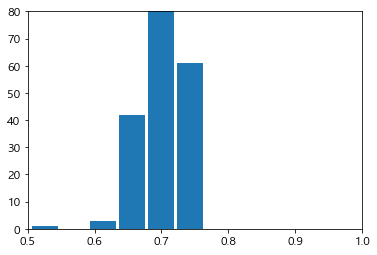

In [24]:
plt.axis([0.5,1,0,80])
plt.hist(score_list['LR'],bins=10,rwidth=0.9)

In [25]:
score_list.describe()

,LR,DT,SVM
count,197.000000,197.000000,197.000000
mean,0.697263,0.615050,0.669055
std,0.042074,0.041125,0.051077
min,0.331269,0.303406,0.436533
25%,0.678019,0.591331,0.647059
50%,0.702786,0.620438,0.678019
75%,0.721362,0.643963,0.702786
max,0.764706,0.699690,0.743034


In [56]:
roc_auc_score

,LR,SVM
006840,[0.6907301135882722],[0.6060213633978297]
027410,[0.7139381658456088],[0.6024583201883176]
138930,[0.7223267708936498],[0.5706933989577301]
001040,[0.6076380813953488],[0.4995687984496124]
079160,[0.6435020229232448],[0.48206647161631083]
000120,[0.7419004992669206],[0.5748115370029976]
097950,[0.7795106775512173],[0.7236232530658017]
005830,[0.732626440402987],[0.6028145347616047]
000990,[0.6543685105459283],[0.5741953378435416]
114090,[0.7511793476687987],[0.6038621827337713]


In [60]:
CM.loc["006840"]

LR     [[[254, 355], [119, 560]]]
DT     [[[256, 353], [192, 487]]]
SVM     [[[129, 480], [93, 586]]]
Name: 006840, dtype: object

In [57]:
CM.loc["006840"]['LR']

[array([[254, 355],
        [119, 560]], dtype=int64)]

In [58]:
CM.loc["006840"]['DT']

[array([[256, 353],
        [192, 487]], dtype=int64)]

In [59]:
CM.loc["006840"]['SVM']

[array([[129, 480],
        [ 93, 586]], dtype=int64)]